In [1]:
# These scripts are used to parse my data into

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import os

target_dir = "Bike 07-06-23 8:52"
target_dir2 = "Bike 07-06-23 14:27"

In [2]:
from statistics import mean

def time_diff(df):
    res = []
    for i in range(len(df["Time (s)"]) - 1):
        val1 = df["Time (s)"][i]
        val2 = df["Time (s)"][i + 1]
        
        res.append(val2 - val1)
    return mean(res)

def read_phyphox(parent_dir):
    acc = pd.read_csv(os.path.join(parent_dir, "Phyphox", "Accelerometer.csv"))
    gyro = pd.read_csv(os.path.join(parent_dir, "Phyphox", "Gyroscope.csv"))
    loc = pd.read_csv(os.path.join(parent_dir, "Phyphox", "Location.csv"))
        
    data_len = min(len(acc), len(gyro))
    acc = acc[0:data_len]
    gyro = gyro[0:data_len]
        
    time_step = mean([time_diff(acc), time_diff(gyro)])
    
    for i in range(data_len):
        time = time_step * i
        acc["Time (s)"][i] = time
        gyro["Time (s)"][i] = time
    
    acc.set_index('Time (s)', inplace=True)
    gyro.set_index('Time (s)', inplace=True)
    loc.set_index('Time (s)', inplace=True)
        
            
    merged = acc.join(gyro, how="outer")
    merged = pd.concat([merged, loc]).sort_index().interpolate()
    
    # Rename columns
    merged.index.names = ["time"]
    merged.rename(inplace=True, columns={
        "Acceleration x (m/s^2)": "acceleration_x",
        "Acceleration y (m/s^2)": "acceleration_y",
        "Acceleration z (m/s^2)": "acceleration_z",
        "Gyroscope x (rad/s)": "gyroscope_x",
        "Gyroscope y (rad/s)": "gyroscope_y",
        "Gyroscope z (rad/s)": "gyroscope_z",
        "Latitude (°)": "latitude",
        "Longitude (°)": "longitude",
        "Height (m)": "height",
        "Velocity (m/s)": "velocity",
        "Direction (°)": "direction",
        "Horizontal Accuracy (m)": "h_accuracy",
        "Vertical Accuracy (m)": "v_accuracy",

    })
    merged = merged.dropna()
    
    time_df = pd.read_csv(os.path.join(parent_dir, "Phyphox", "meta", "time.csv"))
    start_time = time_df.loc[time_df["event"] == "START"]["system time"][0]
    
    merged.reset_index(inplace=True)
    merged['time'] = pd.to_datetime(merged['time'] + start_time, unit='s')
    return merged

read_phyphox(target_dir)

,time,acceleration_x,acceleration_y,acceleration_z,gyroscope_x,gyroscope_y,gyroscope_z,latitude,longitude,height,velocity,direction,h_accuracy,v_accuracy
0,2023-06-07 06:22:51.237444878,1.479975,4.688025,8.505450,-0.083256,-0.035956,-0.047644,52.278535,4.824785,-67.529845,0.758701,64.440002,9.10,91.699997
1,2023-06-07 06:22:51.357940912,0.751950,3.868050,9.076950,-0.041250,-0.046475,-0.062150,52.278468,4.824891,-69.529879,0.701824,58.365002,7.05,89.599998
2,2023-06-07 06:22:51.751848936,1.387300,4.062050,8.925950,-0.119212,0.199558,-0.065450,52.278402,4.824997,-71.529913,0.644947,52.290001,5.00,87.500000
3,2023-06-07 06:22:52.240046024,2.022650,4.256050,8.774950,-0.197175,0.445592,-0.068750,52.278388,4.825015,-74.229921,1.020694,24.639999,3.50,85.500000
4,2023-06-07 06:22:52.357411385,2.658000,4.450050,8.623950,-0.275137,0.691625,-0.072050,52.278392,4.825022,-74.629912,0.946574,24.105000,3.40,82.450001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3568,2023-06-07 06:52:37.411697626,6.423000,-10.324051,1.669050,0.150287,-0.078237,-0.280775,52.334605,4.864740,-33.228580,2.067639,134.669998,5.90,13.000000
3569,2023-06-07 06:52:38.411168098,13.989000,-12.897000,-1.638000,1.387787,3.768462,-3.214887,52.334605,4.864740,-33.228580,2.067639,134.669998,5.90,13.000000
3570,2023-06-07 06:52:39.410638571,0.193950,3.823950,9.574950,-0.194150,0.261525,-0.985875,52.334605,4.864740,-33.228580,2.067639,134.669998,5.90,13.000000
3571,2023-06-07 06:52:40.410109043,0.586050,4.098000,7.506001,-0.145200,0.679525,0.005225,52.334605,4.864740,-33.228580,2.067639,134.669998,5.90,13.000000


In [3]:
def read_samsung_health(parent_dir):
    files = os.scandir(os.path.join(parent_dir, "SamsungHealth"))
    filename = next(filter(lambda file: "com.samsung.health.exercise.live_data.json" in file.name, files)).name
        
    df = pd.read_json(os.path.join(parent_dir, "SamsungHealth", filename))
    df = df[["start_time", "heart_rate"]].dropna()

    return df

read_samsung_health(target_dir)

,start_time,heart_rate
1,2023-06-07 06:22:31.971,97.0
3,2023-06-07 06:22:41.550,90.0
5,2023-06-07 06:22:43.547,89.0
6,2023-06-07 06:22:51.541,100.0
8,2023-06-07 06:23:01.628,101.0
...,...,...
419,2023-06-07 06:52:32.054,154.0
420,2023-06-07 06:52:42.056,153.0
421,2023-06-07 06:52:52.057,157.0
422,2023-06-07 06:53:01.531,154.0


In [4]:
def read_combined(parent_dir):
    pp = read_phyphox(parent_dir)
    sh = read_samsung_health(parent_dir)
    
    pp["heart_rate"] = np.nan
    
    
    # Finds the time intervals of the heart rate measurements and update the phyphox heart rate accordingly
    # This is done as samsung measurements are not very fine grained and only give use relatively large
    # time intervals
    for i in range(len(sh) - 1):
        row1 = sh.iloc[i]
        row2 = sh.iloc[i + 1]
        pp.loc[(pp["time"] >= row1["start_time"]) & (pp["time"] < row2["start_time"]), "heart_rate"] = row1["heart_rate"]
    
    return pp.dropna()

read_combined(target_dir2)

,time,acceleration_x,acceleration_y,acceleration_z,gyroscope_x,gyroscope_y,gyroscope_z,latitude,longitude,height,velocity,direction,h_accuracy,v_accuracy,heart_rate
0,2023-06-07 11:56:22.357122660,1.551000,4.879500,8.588551,-0.002406,0.278644,0.136813,52.335309,4.864779,0.772433,0.000000,0.000000,56.099998,8.217778,96.0
1,2023-06-07 11:56:22.427900553,0.969000,4.608000,8.962050,0.100100,0.096112,0.175863,52.335226,4.864760,0.647304,0.255560,50.595001,44.199999,9.563334,96.0
2,2023-06-07 11:56:22.677867651,0.651000,4.396950,8.713051,-0.044825,0.074112,0.055825,52.335142,4.864740,0.522175,0.511119,101.190002,32.299999,10.908889,96.0
3,2023-06-07 11:56:22.927834511,0.694050,4.236000,9.060000,-0.040838,0.071088,0.033825,52.335059,4.864721,0.397047,0.766679,151.785004,20.400000,12.254445,96.0
4,2023-06-07 11:56:23.049318075,0.620025,4.191975,9.090001,-0.037331,0.059606,0.022344,52.334975,4.864702,0.271918,1.022238,202.380005,8.500000,13.600000,96.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7508,2023-06-07 12:21:23.229163408,-1.780950,-9.523951,-2.586000,1.098350,-0.448388,-0.719262,52.278317,4.825148,-53.089947,0.000000,293.380005,2.000000,6.920000,151.0
7509,2023-06-07 12:21:23.479130268,1.044000,-9.225000,1.839000,0.159362,0.112613,0.077688,52.278317,4.825149,-53.069946,0.000000,293.380005,2.000000,7.080000,151.0
7510,2023-06-07 12:21:23.729097128,-1.207050,-9.472051,-1.357050,0.081400,-0.102437,-0.004262,52.278317,4.825149,-53.049946,0.000000,293.380005,2.000000,7.240000,151.0
7511,2023-06-07 12:21:23.875818014,-0.524025,-9.304050,-0.554025,0.733425,-0.715412,-0.340313,52.278317,4.825150,-53.029946,0.000000,293.380005,2.000000,7.400000,151.0


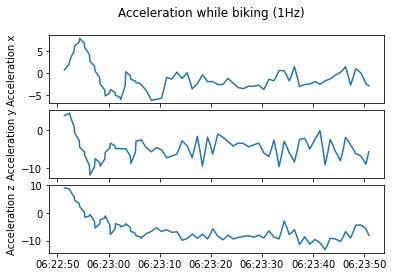

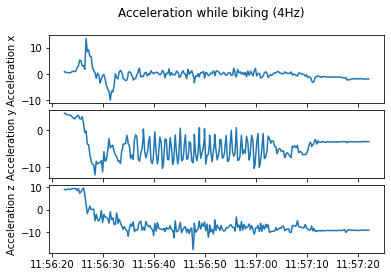

In [5]:
# Plot 60 seconds of accelerometer data for 1 and 4 hz
interval = 60

df_1hz = read_combined(target_dir)
begin_timestamp = df_1hz["time"][0].timestamp()
df_1hz = df_1hz[(df_1hz["time"] >= pd.to_datetime(begin_timestamp, unit='s')) & (df_1hz["time"] < pd.to_datetime(begin_timestamp + interval, unit='s'))]

df_4hz = read_combined(target_dir2)
begin_timestamp = df_4hz["time"][0].timestamp()
df_4hz = df_4hz[(df_4hz["time"] >= pd.to_datetime(begin_timestamp, unit='s')) & (df_4hz["time"] < pd.to_datetime(begin_timestamp + interval, unit='s'))]

fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True)

fig.suptitle("Acceleration while biking (1Hz)")

ax1.plot(df_1hz["time"], df_1hz["acceleration_x"])
ax1.set_ylabel("Acceleration x")

ax2.plot(df_1hz["time"], df_1hz["acceleration_y"])
ax2.set_ylabel("Acceleration y")

ax3.plot(df_1hz["time"], df_1hz["acceleration_z"])
ax3.set_ylabel("Acceleration z")

plt.subplots_adjust(hspace=0.1)
fig.align_labels()

plt.savefig("biking_acceleration_1hz.pdf", format="pdf", bbox_inches="tight")

fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True)

fig.suptitle("Acceleration while biking (4Hz)")

ax1.plot(df_4hz["time"], df_4hz["acceleration_x"])
ax1.set_ylabel("Acceleration x")

ax2.plot(df_4hz["time"], df_4hz["acceleration_y"])
ax2.set_ylabel("Acceleration y")

ax3.plot(df_4hz["time"], df_4hz["acceleration_z"])
ax3.set_ylabel("Acceleration z")

plt.subplots_adjust(hspace=0.1)
fig.align_labels()

plt.savefig("biking_acceleration_4hz.pdf", format="pdf", bbox_inches="tight")

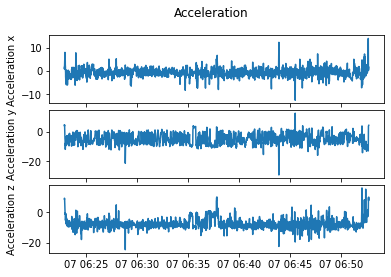

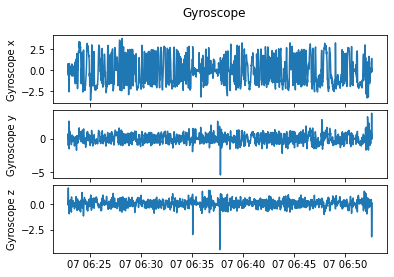

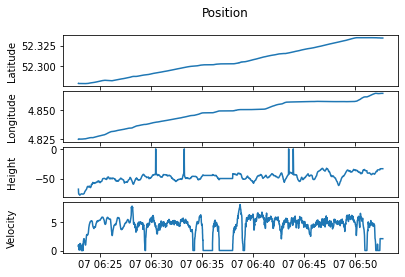

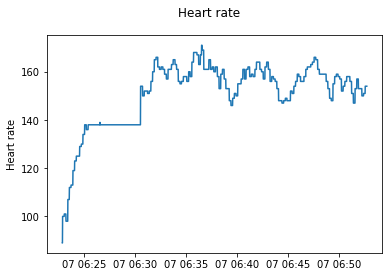

In [6]:
target_tram = "Tram 08-06-23 11:05"
target_walk = "Walk 08-06-23 10:41"

df = read_combined(target_dir)

# Acceleration figure
fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True)

fig.suptitle("Acceleration")

ax1.plot(df["time"], df["acceleration_x"])
ax1.set_ylabel("Acceleration x")

ax2.plot(df["time"], df["acceleration_y"])
ax2.set_ylabel("Acceleration y")

ax3.plot(df["time"], df["acceleration_z"])
ax3.set_ylabel("Acceleration z")

plt.subplots_adjust(hspace=0.1)
fig.align_labels()

# Gyroscope figure
fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True)

fig.suptitle("Gyroscope")

ax1.plot(df["time"], df["gyroscope_x"])
ax1.set_ylabel("Gyroscope x")

ax2.plot(df["time"], df["gyroscope_y"])
ax2.set_ylabel("Gyroscope y")

ax3.plot(df["time"], df["gyroscope_z"])
ax3.set_ylabel("Gyroscope z")

plt.subplots_adjust(hspace=0.1)
fig.align_labels()

# Position figure
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, sharex=True)

fig.suptitle("Position")

ax1.plot(df["time"], df["latitude"])
ax1.set_ylabel("Latitude")

ax2.plot(df["time"], df["longitude"])
ax2.set_ylabel("Longitude")

ax3.plot(df["time"], df["height"])
ax3.set_ylabel("Height")

ax4.plot(df["time"], df["velocity"])
ax4.set_ylabel("Velocity")

plt.subplots_adjust(hspace=0.1)
fig.align_labels()

# Position figure
fig, ax = plt.subplots(1, sharex=True)

fig.suptitle("Heart rate")

ax.plot(df["time"], df["heart_rate"])
ax.set_ylabel("Heart rate")


plt.subplots_adjust(hspace=0.1)
fig.align_labels()

In [7]:
import Python3Code.Chapter3.OutlierDetection as od

def plot_outliers(df, col):
    plt.plot(df.loc[df[col + "_outlier"] == False, "time"], df.loc[df[col + "_outlier"] == False, col], 'bo')
    plt.plot(df.loc[df[col + "_outlier"] == True, "time"], df.loc[df[col + "_outlier"] == True, col], 'rx')

def set_outliers(df, outliers, col):
    df[col + "_outlier"] = False
    df.loc[out.index, col + "_outlier"] = True
    
distribution_od = od.DistributionBasedOutlierDetection()
distance_od = od.DistanceBasedOutlierDetection()
col = "acceleration_x"

df = read_combined(target_dir2)

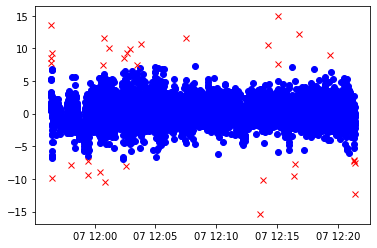

In [8]:
# Chauvenet
df[col + "_outlier"] = False
df_out = distribution_od.chauvenet(df, col, 2)

plot_outliers(df_out, col)

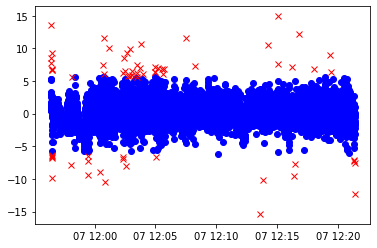

In [9]:
# Quantiles
import vutil   

df[col + "_outlier"] = False

out = vutil.find_outliers(df, "acceleration_x")
set_outliers(df, out, "acceleration_x")


plot_outliers(df, "acceleration_x")

Applying mixture models


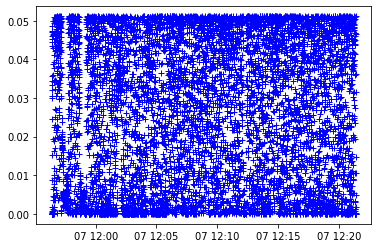

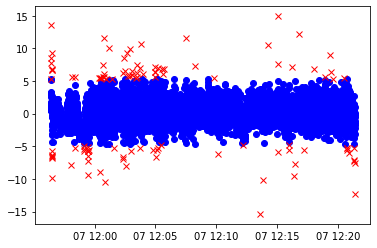

In [10]:
# Mixture

df[col + "_outlier"] = False
df.drop([col + "_mixture"], axis=1, errors='ignore', inplace=True)

df = distribution_od.mixture_model(df, col)

plt.plot(df["time"], df[col + "_mixture"], 'b+')
df.loc[df[col + "_mixture"] < 0.00001, col + "_outlier"] = True

plt.figure()
plot_outliers(df, col)

Calculating simple distance-based criterion.


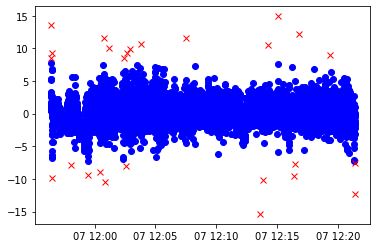

In [11]:
# Simple distance based

df[col + "_outlier"] = False

df = distance_od.simple_distance_based(df, ["acceleration_x"], "euclidean", 0.5, 1/500)

df[col + "_outlier"] = df["simple_dist_outlier"]
plot_outliers(df, col)

In [12]:
# Calculate Local outlier factor
# Might take some time

df[col + "_outlier"] = False

df = distance_od.local_outlier_factor(df, ["acceleration_x"], "euclidean", 2)

#df[col + "_outlier"] = df["simple_dist_outlier"]
#plot_outliers(df, col)
df

Calculating local outlier factor.
Completed 0 steps for LOF.
Completed 100 steps for LOF.
Completed 200 steps for LOF.
Completed 300 steps for LOF.
Completed 400 steps for LOF.
Completed 500 steps for LOF.
Completed 600 steps for LOF.
Completed 700 steps for LOF.
Completed 800 steps for LOF.
Completed 900 steps for LOF.
Completed 1000 steps for LOF.
Completed 1100 steps for LOF.
Completed 1200 steps for LOF.
Completed 1300 steps for LOF.
Completed 1400 steps for LOF.
Completed 1500 steps for LOF.
Completed 1600 steps for LOF.
Completed 1700 steps for LOF.
Completed 1800 steps for LOF.
Completed 1900 steps for LOF.
Completed 2000 steps for LOF.
Completed 2100 steps for LOF.
Completed 2200 steps for LOF.
Completed 2300 steps for LOF.
Completed 2400 steps for LOF.
Completed 2500 steps for LOF.
Completed 2600 steps for LOF.
Completed 2700 steps for LOF.
Completed 2800 steps for LOF.
Completed 2900 steps for LOF.
Completed 3000 steps for LOF.
Completed 3100 steps for LOF.
Completed 3200 ste

,time,acceleration_x,acceleration_y,acceleration_z,gyroscope_x,gyroscope_y,gyroscope_z,latitude,longitude,height,velocity,direction,h_accuracy,v_accuracy,heart_rate,acceleration_x_outlier,acceleration_x_mixture,simple_dist_outlier,lof
0,2023-06-07 11:56:22.357122660,1.551000,4.879500,8.588551,-0.002406,0.278644,0.136813,52.335309,4.864779,0.772433,0.000000,0.000000,56.099998,8.217778,96.0,False,0.015239,False,1.000000
1,2023-06-07 11:56:22.427900553,0.969000,4.608000,8.962050,0.100100,0.096112,0.175863,52.335226,4.864760,0.647304,0.255560,50.595001,44.199999,9.563334,96.0,False,0.034326,False,1.000000
2,2023-06-07 11:56:22.677867651,0.651000,4.396950,8.713051,-0.044825,0.074112,0.055825,52.335142,4.864740,0.522175,0.511119,101.190002,32.299999,10.908889,96.0,False,0.044559,False,1.000000
3,2023-06-07 11:56:22.927834511,0.694050,4.236000,9.060000,-0.040838,0.071088,0.033825,52.335059,4.864721,0.397047,0.766679,151.785004,20.400000,12.254445,96.0,False,0.043351,False,1.000000
4,2023-06-07 11:56:23.049318075,0.620025,4.191975,9.090001,-0.037331,0.059606,0.022344,52.334975,4.864702,0.271918,1.022238,202.380005,8.500000,13.600000,96.0,False,0.045378,False,0.024764
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7508,2023-06-07 12:21:23.229163408,-1.780950,-9.523951,-2.586000,1.098350,-0.448388,-0.719262,52.278317,4.825148,-53.089947,0.000000,293.380005,2.000000,6.920000,151.0,False,0.004914,False,1.000000
7509,2023-06-07 12:21:23.479130268,1.044000,-9.225000,1.839000,0.159362,0.112613,0.077688,52.278317,4.825149,-53.069946,0.000000,293.380005,2.000000,7.080000,151.0,False,0.031659,False,1.000000
7510,2023-06-07 12:21:23.729097128,-1.207050,-9.472051,-1.357050,0.081400,-0.102437,-0.004262,52.278317,4.825149,-53.049946,0.000000,293.380005,2.000000,7.240000,151.0,False,0.014701,False,1.000000
7511,2023-06-07 12:21:23.875818014,-0.524025,-9.304050,-0.554025,0.733425,-0.715412,-0.340313,52.278317,4.825150,-53.029946,0.000000,293.380005,2.000000,7.400000,151.0,False,0.036326,False,1.000000


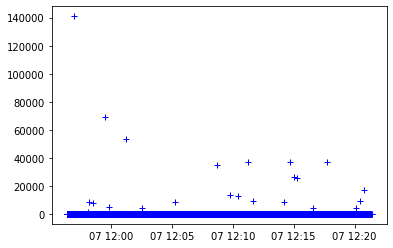

In [13]:
# Plot LOF
plt.plot(df["time"], df["lof"], 'b+')

Figure saved to figures/figure_1.png
Figure saved to figures/figure_1.pdf
Figure saved to figures/figure_2.png
Figure saved to figures/figure_2.pdf


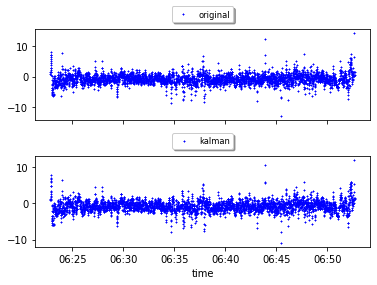

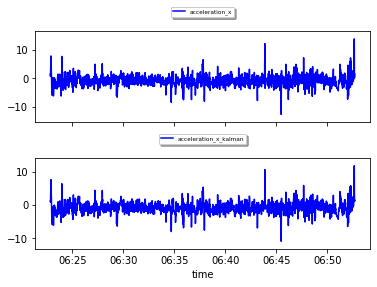

In [20]:
#The Kalman Filter
# used for detecting outliers and removing them in single step
import Python3Code.Chapter3.KalmanFilters as kf
from Python3Code.util.VisualizeDataset import VisualizeDataset

df = read_combined(target_dir)

DataViz = VisualizeDataset()

KalFilter = kf.KalmanFilters()
kalman_dataset = KalFilter.apply_kalman_filter(df, col)

kalman_dataset.set_index("time", inplace=True)

DataViz.plot_imputed_values(kalman_dataset, ['original', 'kalman'], col, kalman_dataset[col + '_kalman'])
DataViz.plot_dataset(kalman_dataset, [col, col + '_kalman'], ['exact', 'exact'], ['line', 'line'])